## PEFT

In [1]:
!pip install -q -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 25.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00:00:0100:01


In [2]:
!pip install -q -U transformers datasets peft bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 88.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [3]:
!pip install evaluate
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.6 MB/s eta 0:00:00


In [4]:
from evaluate import load as hf_load
import transformers
import torch
import requests
from PIL import Image
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration

2025-06-15 18:47:16.659683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750013236.894960      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750013236.972581      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
from huggingface_hub import login
login(token = "....")

# Fine-Tuning PaliGemma

In [ ]:
import pandas as pd
import numpy as np 
from pathlib import Path
from peft import get_peft_model, LoraConfig
from transformers import (
    PaliGemmaProcessor,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    BitsAndBytesConfig,
)
from peft import LoraConfig, get_peft_model
from PIL import Image
from torch.utils.data import Dataset
import torch
import shutil
import os
from evaluate import load
import wandb

# Initialize W&B
wandb.login(key=".....")
wandb.init(project="vlm_for_image_captioning", name="paligemma_peft")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: esrasekerci (esrasekerci-metu-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
data_dir = Path("/kaggle/input/di725-dataset")
image_dir = data_dir / "resized"
caption_file = data_dir / "captions.csv"

In [8]:
df = pd.read_csv(caption_file)
df.head()

,source,split,image,caption_1,caption_2,caption_3,caption_4,caption_5
0,NWPU,test,NWPU_31430.jpg,A gray plane on the runway and the lawn beside .,A grey plane is on the runway by the lawn .,There is an airplane on the runway with a larg...,A plane is parked on the runway next to the gr...,There is a plane on the runway beside the grass .
1,NWPU,test,NWPU_31431.jpg,Three small planes parked in a line on the air...,"There are four aircraft on the open ground, Th...",There are many planes of different sizes in a ...,Four planes are parked on the runway .,Four planes of different sizes were on the mar...
2,NWPU,test,NWPU_31432.jpg,A plane parked in a line on the airport with s...,A white plane was parked on the instruction li...,An airplane parked in an open area with many c...,A plane is parked on the open space .,There is 1 plane on the ground marked .
3,NWPU,test,NWPU_31433.jpg,A small plane and a big plane parked next to b...,A white plane and a gray plane parked at the b...,Two planes of different sizes are neatly parke...,A large plane and a small plane are parked nea...,Two planes are on the marked ground .
4,NWPU,test,NWPU_31434.jpg,Two planes parked next to boarding bridges .,Two aircraft were parked at the departure gates .,Two planes of different sizes are neatly parke...,Two planes are parked next to the terminal .,Two planes are on the marked ground .


In [9]:
def select_longest_caption(row):
    captions = [row[f"caption_{i}"] for i in range(1, 6)]
    longest = max(captions, key=lambda x: len(x.split()))
    return longest

df["caption"] = df.apply(select_longest_caption, axis=1)

In [10]:
df.drop(columns=[f"caption_{i}" for i in range(1, 6)], inplace=True)

In [11]:
df.head()

,source,split,image,caption
0,NWPU,test,NWPU_31430.jpg,There is an airplane on the runway with a larg...
1,NWPU,test,NWPU_31431.jpg,"There are four aircraft on the open ground, Th..."
2,NWPU,test,NWPU_31432.jpg,An airplane parked in an open area with many c...
3,NWPU,test,NWPU_31433.jpg,A white plane and a gray plane parked at the b...
4,NWPU,test,NWPU_31434.jpg,Two planes of different sizes are neatly parke...


In [12]:
split_counts = df["split"].value_counts()
split_percent = df["split"].value_counts(normalize=True) * 100

split_info = pd.DataFrame({
    "Count": split_counts,
    "Percentage": split_percent.round(2)
})

print(split_info)

       Count  Percentage
split                   
train  35614       79.99
test    4454       10.00
val     4453       10.00


In [13]:
# Split
train_df = df[df["split"] == "train"].copy()
val_df = df[df["split"] == "val"].copy()
test_df = df[df["split"] == "test"].copy()

# Drop unnecessary columns
train_df = train_df[["image", "caption"]].reset_index(drop=True)
val_df = val_df[["image", "caption"]].reset_index(drop=True)
test_df = test_df[["image", "caption"]].reset_index(drop=True)

In [14]:
train_df

,image,caption
0,RSICD_0.jpg,many planes are parked next to a long building...
1,RSICD_1.jpg,the airport here is full of airplanes and cont...
2,RSICD_2.jpg,many planes are parked in an airport near many...
3,RSICD_3.jpg,many planes are parked near a large building o...
4,RSICD_4.jpg,several buildings and green trees are around a...
...,...,...
35609,UCM_2075.jpg,There is a small tennis court and surrounded b...
35610,UCM_2076.jpg,There are two tennis courts surrounded by some...
35611,UCM_2077.jpg,There is a small tennis court and surrounded b...
35612,UCM_2078.jpg,There is a tennis court surrounded by some car...


In [73]:
import gc, torch
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [16]:
# Dataset Class
class ImageCaptionDataset(Dataset):
    def __init__(self, dataframe, image_dir):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = Path(image_dir)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = self.image_dir / row["image"]
        image = Image.open(image_path).convert("RGB")
        return {"image": image, "caption": row["caption"]}

    def __len__(self):
        return len(self.df)

# Create Datasets
train_ds = ImageCaptionDataset(train_df, image_dir)
val_ds = ImageCaptionDataset(val_df, image_dir)
test_ds = ImageCaptionDataset(test_df, image_dir)

In [16]:
# Dataset Class
class ImageCaptionDataset(Dataset):
    def __init__(self, dataframe, image_dir):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = Path(image_dir)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = self.image_dir / row["image"]
        image = Image.open(image_path).convert("RGB")
        return {"image": image, "caption": row["caption"]}

    def __len__(self):
        return len(self.df)

# Create Datasets
train_ds = ImageCaptionDataset(train_df, image_dir)
val_ds = ImageCaptionDataset(val_df, image_dir)
test_ds = ImageCaptionDataset(test_df, image_dir)

# Processor and Prompt Template
model_id = "google/paligemma-3b-pt-224"
device = "cuda"
processor = PaliGemmaProcessor.from_pretrained(model_id)
prompt_template = "<image> explain the layout of the terrain and infrastructure."

# Collate Function
def collate_fn(examples):
    prompt = "<image> explain the layout of the terrain and infrastructure."
    captions = [ex["caption"] for ex in examples]
    images = [ex["image"] for ex in examples]
    text_with_targets = [f"{prompt} {caption}" for caption in captions]

    tokens = processor(
        text=text_with_targets,
        images=images,
        return_tensors="pt",
        padding="longest"
    )

    # Set input_ids as labels (for causal language modeling)
    tokens["labels"] = tokens["input_ids"].clone()

    # Move tensors to device
    for k, v in tokens.items():
        if isinstance(v, torch.Tensor):
            if v.dtype in [torch.float32, torch.float64]:
                tokens[k] = v.to(device, dtype=torch.bfloat16)
            else:
                tokens[k] = v.to(device)
    return tokens

model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16).to(device)
for param in model.vision_tower.parameters():
      param.requires_grad = False
for param in model.multi_modal_projector.parameters():
      param.requires_grad = False
    
# Quantization + LoRA Config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM"
)

# Load Model with Quantization + LoRA
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# Evaluation Metrics
bleu = load("bleu")
meteor = load("meteor")
bertscore = load("bertscore")

def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    decoded_preds = processor.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    return {
        "bleu": bleu.compute(predictions=decoded_preds, references=[[l] for l in decoded_labels])["bleu"],
        "meteor": meteor.compute(predictions=decoded_preds, references=decoded_labels)["meteor"],
        "bertscore_f1": bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="en")["f1"]
    }

args = TrainingArguments(
    output_dir="finetuned_paligemma",
    max_steps=1000,
    num_train_epochs=2,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=2e-5,
    weight_decay=1e-6,
    warmup_steps=2,
    adam_beta2=0.999,
    logging_steps=10,
    optim="adamw_8bit",
    save_strategy="steps",
    save_steps=100,
    save_total_limit=1,
    bf16=True,
    dataloader_pin_memory=False,
    report_to=["wandb"],
    remove_unused_columns=False
)

# Trainer Setup
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

trainable params: 11,298,816 || all params: 2,934,765,296 || trainable%: 0.3850


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [17]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,18.547900
20,18.098500
30,17.411500
40,16.662300
50,16.060000
60,15.344400
70,14.778100
80,14.252000
90,13.792500
100,13.377400


TrainOutput(global_step=1000, training_loss=12.26443236541748, metrics={'train_runtime': 8124.704, 'train_samples_per_second': 0.985, 'train_steps_per_second': 0.123, 'total_flos': 3.3232563912330624e+16, 'train_loss': 12.26443236541748, 'epoch': 0.22463076318301792})

In [18]:
# Define save path
save_path = "finetuned_paligemma_riscm_final"

# Save model and processor
model.save_pretrained(save_path)
processor.save_pretrained(save_path)

# Create a zip archive
shutil.make_archive("paligemma_riscm_model", "zip", save_path)

print("Training complete. Model and processor saved and zipped for download.")

Training complete. Model and processor saved and zipped for download.


In [30]:
from tqdm import tqdm

generated_ids_list = []
references = []

model.eval()

for i, sample in enumerate(tqdm(test_ds)):
    try:
        inputs = processor(
            text="<image> explain the layout of the terrain and infrastructure.",
            images=sample["image"],
            return_tensors="pt",
            padding="longest"
        ).to(model.device)

        with torch.no_grad(), torch.autocast("cuda", dtype=torch.bfloat16):
            output_ids = model.generate(
                **inputs,
                max_new_tokens=30
            )

        generated_ids_list.append(output_ids[0].cpu())
        references.append(sample["caption"])

        if i % 50 == 0:
            torch.cuda.empty_cache()
            gc.collect()

    except Exception as e:
        print(f"Error: {e}")
        continue

# Decode all predictions at once
predictions = processor.batch_decode(generated_ids_list, skip_special_tokens=True)

# Compute metrics
results = {
    "BLEU": bleu.compute(predictions=predictions, references=[[ref] for ref in references])["bleu"],
    "METEOR": meteor.compute(predictions=predictions, references=references)["meteor"],
    "BERTScore_F1": sum(bertscore.compute(predictions=predictions, references=references, lang="en")["f1"]) / len(predictions)
}

# Display results
print("Test Set Evaluation Results:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

100%|██████████| 4454/4454 [3:27:54<00:00,  2.80s/it]  


Test Set Evaluation Results:
BLEU: 0.0000
METEOR: 0.1010
BERTScore_F1: 0.8287


In [32]:
results

{'BLEU': 0.0,
 'METEOR': 0.10103276766919533,
 'BERTScore_F1': 0.8287448578208457}

In [31]:
results_df = pd.DataFrame({
    "image": [test_ds.df.iloc[i]["image"] for i in range(len(predictions))],
    "reference_caption": references,
    "generated_caption": predictions
})

results_df.to_csv("test_peft_results.csv", index=False, encoding="utf-8")

## XAI

In [49]:
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration

# Load the saved processor and model
save_path = "/kaggle/working/finetuned_paligemma_riscm_final"

processor = PaliGemmaProcessor.from_pretrained(save_path)
model = PaliGemmaForConditionalGeneration.from_pretrained(save_path, torch_dtype=torch.bfloat16).to("cuda")
model.eval()

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

PaliGemmaForConditionalGeneration(
  (model): PaliGemmaModel(
    (vision_tower): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
          (position_embedding): Embedding(256, 1152)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-26): 27 x SiglipEncoderLayer(
              (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
              (self_attn): SiglipAttention(
                (k_proj): lora.Linear(
                  (base_layer): Linear(in_features=1152, out_features=1152, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1152, out_features=8, bias=False)
                  )
                  (lora_B):

In [18]:
!pip install -q captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.8 MB/s eta 0:00:0000:01


In [19]:
import torch
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from transformers import PaliGemmaForConditionalGeneration, PaliGemmaProcessor
from PIL import Image

from transformers import PaliGemmaForConditionalGeneration, PaliGemmaProcessor
from peft import PeftModel
import torch

# Step 1: Load the base model from Hugging Face (required for full architecture)
base_model_id = "google/paligemma-3b-pt-224"
base_model = PaliGemmaForConditionalGeneration.from_pretrained(
    base_model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16
)

# Step 2: Load processor (tokenizer + image processor)
processor = PaliGemmaProcessor.from_pretrained(base_model_id)

# Step 3: Load LoRA adapter from the saved directory
adapter_path = "/kaggle/input/paligemma"
model = PeftModel.from_pretrained(base_model, adapter_path).to("cuda").eval()

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

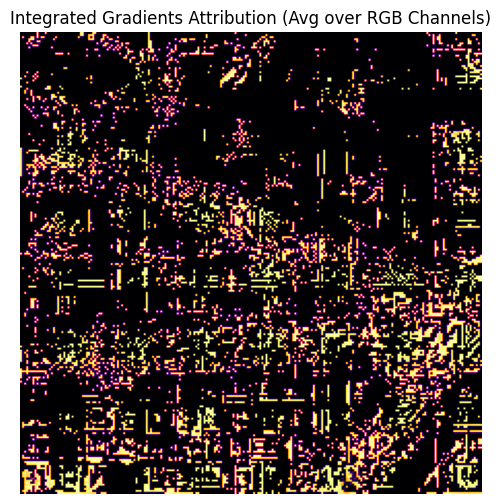

In [44]:
import torch
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# 1. Define Prompt and Test Image
prompt = "<image> explain the layout of the terrain and infrastructure."
example = test_ds[15]  # Use a representative test image and caption
image = example["image"]
caption = example["caption"]

# 2. Preprocess Inputs
model_inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device)
pixel_values = model_inputs["pixel_values"]
input_ids = model_inputs["input_ids"]
attention_mask = model_inputs["attention_mask"]

# 3. Create baseline (black image)
baseline_pixel = torch.zeros_like(pixel_values)

# 4. Define forward function for Captum
def forward_func(pixel_input):
    outputs = model(
        pixel_values=pixel_input,
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    logits = outputs.logits  # [batch_size, seq_len, vocab]
    target_token_id = processor.tokenizer.encode("sand", add_special_tokens=False)[0]
    return logits[:, -1, target_token_id]  # attribution for final token prediction

# 5. Run Integrated Gradients with safe memory usage
ig = IntegratedGradients(forward_func)

attributions, delta = ig.attribute(
    inputs=pixel_values,
    baselines=baseline_pixel,
    target=None,
    return_convergence_delta=True,
    n_steps=20,  # reduce from default 50
    internal_batch_size=1
)

# 6. Visualize per-channel attribution map
attr = attributions.squeeze().detach().cpu()
attr_map = attr.mean(dim=0)  # mean across RGB channels

plt.figure(figsize=(6, 6))
plt.imshow(to_pil_image(attr_map), cmap="inferno")
plt.title("Integrated Gradients Attribution (Avg over RGB Channels)")
plt.axis("off")
plt.show()

Occlusion attribution:   0%|          | 0/1850 [00:00<?, ?it/s]

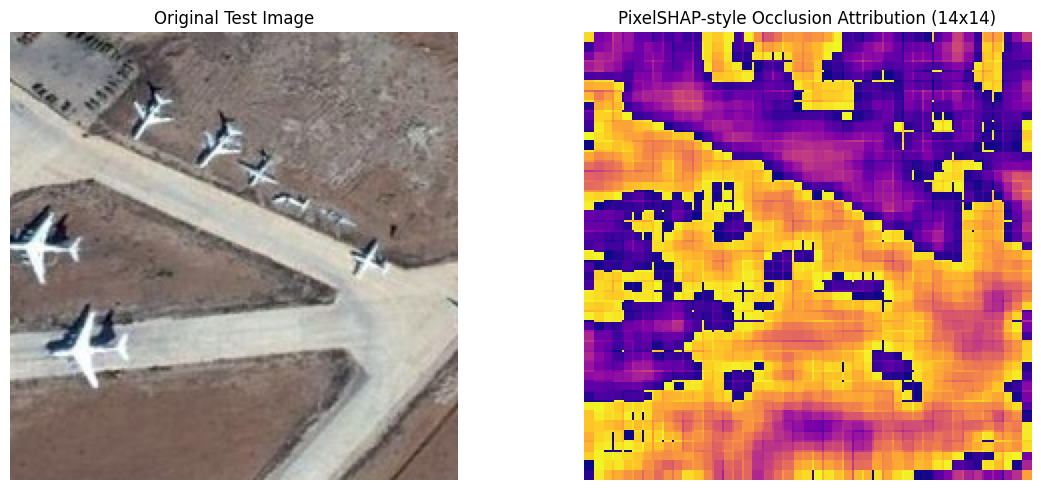

In [56]:
from captum.attr import Occlusion

# 1. Define correct forward function with multiple inputs
def forward_func_occlusion(pixel_input, input_ids, attention_mask):
    outputs = model(
        pixel_values=pixel_input,
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    target_token_id = processor.tokenizer.encode("sand", add_special_tokens=False)[0]
    return outputs.logits[:, -1, target_token_id]

# 2. Initialize Occlusion attribution
occlusion = Occlusion(forward_func_occlusion)

# 3. Run occlusion with correct args
attributions_occ = occlusion.attribute(
    inputs=pixel_values,
    sliding_window_shapes=(3, 14, 14),     # channels, height, width
    strides=(3, 5, 5),                     # smoother occlusion
    baselines=baseline_pixel,
    target=None,                          # optional since forward returns specific index
    additional_forward_args=(input_ids, attention_mask),
    show_progress=True
)

# 4. Visualize
attr_map_occ = attributions_occ.squeeze().cpu().mean(dim=0)  # average over RGB channels

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Test Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(to_pil_image(attr_map_occ), cmap="plasma")
plt.title("PixelSHAP-style Occlusion Attribution (14x14)")
plt.axis("off")
plt.tight_layout()
plt.show()

In [45]:
args = TrainingArguments(
    output_dir="finetuned_paligemma",
    max_steps=500,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=1e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_steps=20,
    optim="adamw_8bit",
    save_strategy="steps",
    save_steps=100,
    save_total_limit=1,
    bf16=True,
    dataloader_pin_memory=False,
    report_to=["wandb"],
    remove_unused_columns=False
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
20,11.704500
40,11.698100
60,11.725800
80,11.668800
100,11.670300
120,11.723800
140,11.679400
160,11.740400


KeyboardInterrupt: 